<a href="https://colab.research.google.com/github/martings/pST_EGFP_Cter_inner_Segmentation/blob/main/Scikit_image_separando_celulas_con_marca_de_GFP_y_calculo_de_radio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import img_as_float, measure, filters, io, morphology, segmentation
from skimage.segmentation import (morphological_chan_vese,checkerboard_level_set)


MAX_HC11_Total_siHuR4.tif


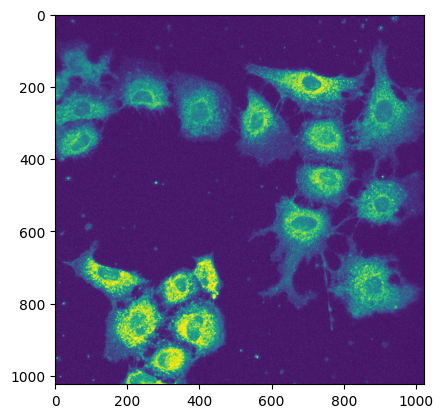

In [4]:
name="MAX_HC11_Total_siHuR4.tif"
print(name)
imgG = io.imread("/content/MAX_HC11_Total_siHuR4.tif")
plt.imshow(imgG)


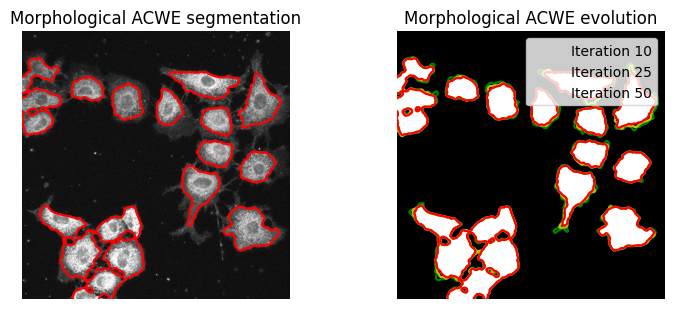

In [5]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
image = img_as_float(imgG)

# Initial level set
init_ls = checkerboard_level_set(image.shape, 10)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 50, init_level_set=init_ls, smoothing=5,
                             iter_callback=callback)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.2),
                                    sharex=True, sharey=True)

ax1.imshow(image, cmap="gray")
ax1.set_axis_off()
ax1.contour(ls, [0.5], colors='r')
ax1.set_title("Morphological ACWE segmentation", fontsize=12)

ax2.imshow(ls, cmap="gray")
ax2.set_axis_off()
contour = ax2.contour(evolution[10], [0.5], colors='g')
contour.collections[0].set_label("Iteration 10")
contour = ax2.contour(evolution[25], [0.5], colors='y')
contour.collections[0].set_label("Iteration 25")
contour = ax2.contour(evolution[50], [0.5], colors='r')
contour.collections[0].set_label("Iteration 50")
ax2.legend(loc="upper right")
title = "Morphological ACWE evolution"
ax2.set_title(title, fontsize=12)

fig.tight_layout()
plt.show()


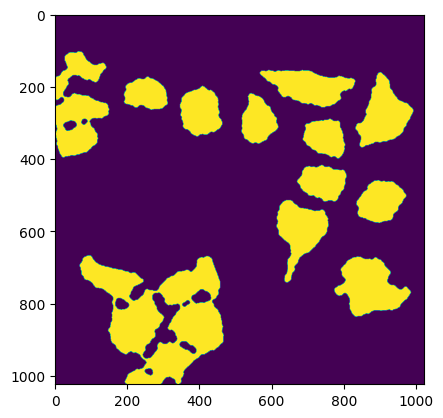

In [6]:
plt.imshow(ls)

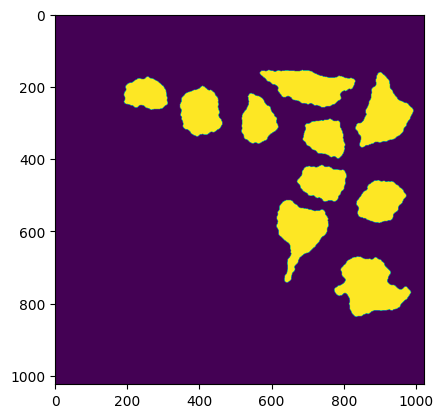

In [8]:
# nomenclar cada celula
msk = segmentation.clear_border(ls)
plt.imshow(msk)


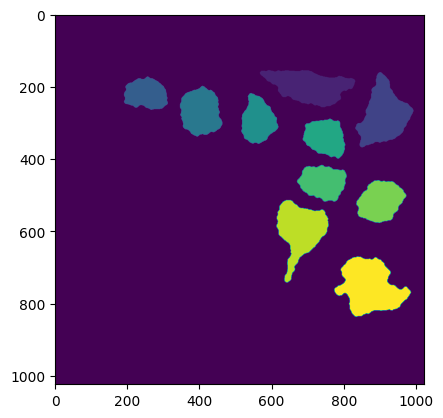

In [9]:
cells = measure.label(msk)
plt.imshow(cells);
# filtrar
for region in measure.regionprops(cells):
    
    if region.area < 500:
        cells[cells == region.label] = 0
        
cells, _, _ = segmentation.relabel_sequential(cells)
plt.imshow(cells)

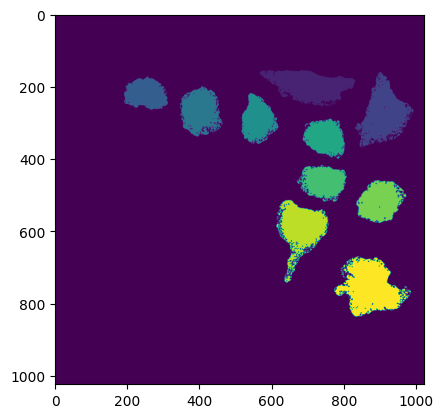

In [10]:
# Buscar nucleos (esto es trivial con un stain nuclear)
nuclei = np.zeros_like(cells)

for label in np.unique(cells):
    
    if label == 0:
        continue
    else:    
        cell_msk = cells==label
        threshold = filters.threshold_otsu(imgG)
        bw = morphology.closing(imgG > threshold)
        nuclei[np.logical_and(cell_msk, bw)] = label


plt.imshow(nuclei)


In [11]:
out = []
for label in np.unique(cells):
    
    if label == 0:
        continue
    else:    
        cell_msk = cells == label
        nuc_msk = nuclei == label
        out.append((label, np.sum(cell_msk), np.sum(imgG[cell_msk]), np.sum(nuc_msk), np.sum(imgG[nuc_msk])))

out = pd.DataFrame(out, columns=('label', 'cell_area', 'cell_integrated_intensity', 'nuclear_area', 'nuclear_integrated_intensity'))


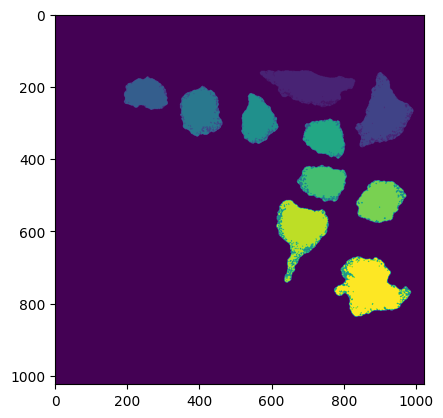

In [12]:
plt.imshow(cells + nuclei)
#out.to_csv('%s.csv' %name) 

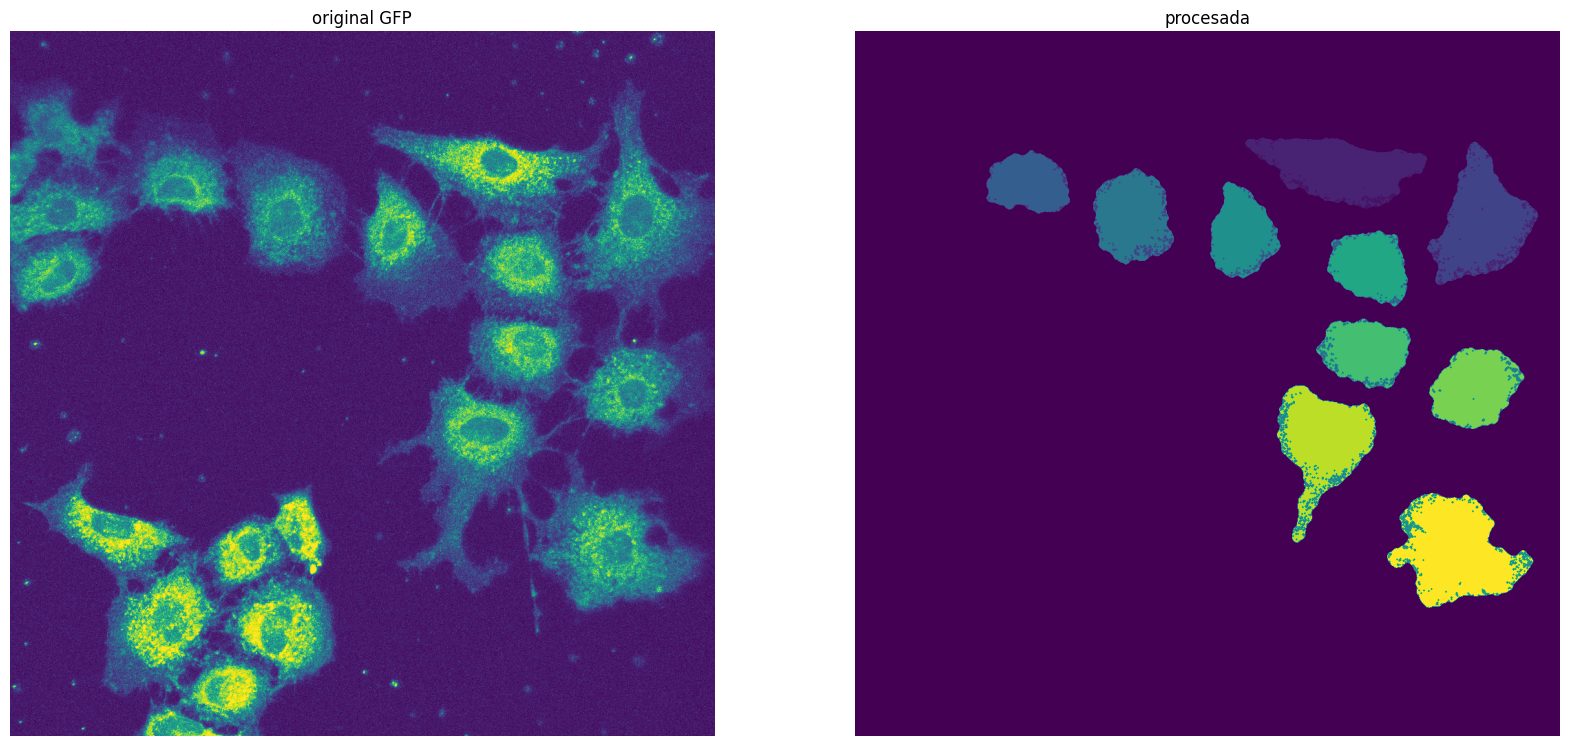

In [13]:
fig, ( ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=2,
                                    figsize=(20, 10),
                                    sharex=True,
                                    sharey=True)

ax1.imshow(imgG)
ax1.set_title('original GFP')
ax1.axis('off')


ax2.imshow(cells + nuclei)
ax2.set_title('procesada')
ax2.axis('off')
fig.show()

In [14]:
from skimage.measure import label

# labeled contains one integer for each pixel in the image,
# where that image indicates the segment to which the pixel belongs
labeled = label(msk)

In [15]:
from skimage.measure import regionprops

# create array in which to store cropped articles
cropped_images = []
cropped_images_nuclei = []
cropped_images_original = []


# define amount of padding to add to cropped image
pad = 1


# for each segment number, find the area of the given segment.
# If that area is sufficiently large, crop out the identified segment.
for region_index, region in enumerate(regionprops(labeled)):
    if region.area < 1000:
        continue
# draw a rectangle around the segmented articles
# bbox describes: min_row, min_col, max_row, max_col
    minr, minc, maxr, maxc = region.bbox
# use those bounding box coordinates to crop the image
    cropped_images.append(cells[minr-pad:maxr+pad, minc-pad:maxc+pad])
    cropped_images_nuclei.append(imgG[minr-pad:maxr+pad, minc-pad:maxc+pad])
    cropped_images_original.append(imgG[minr-pad:maxr+pad, minc-pad:maxc+pad])


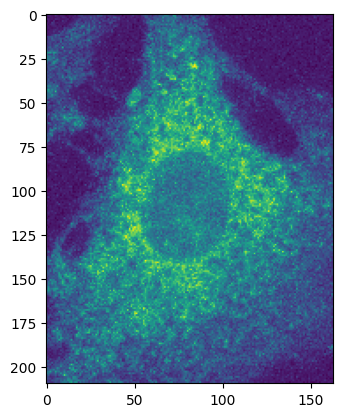

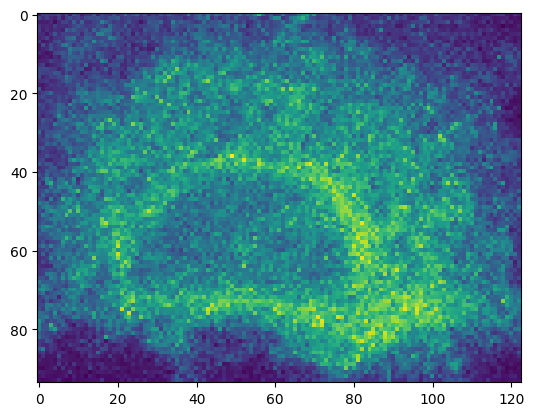

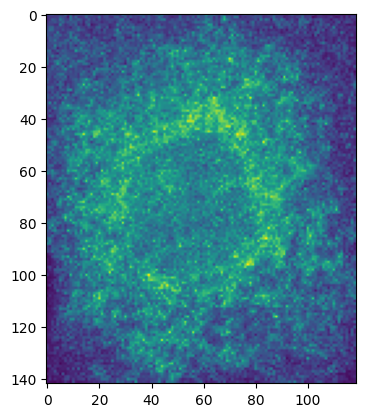

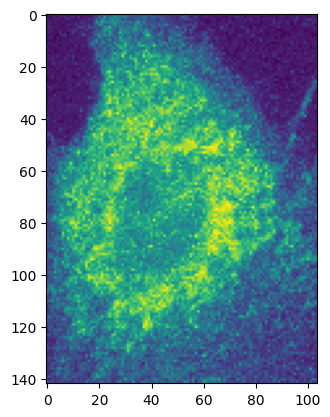

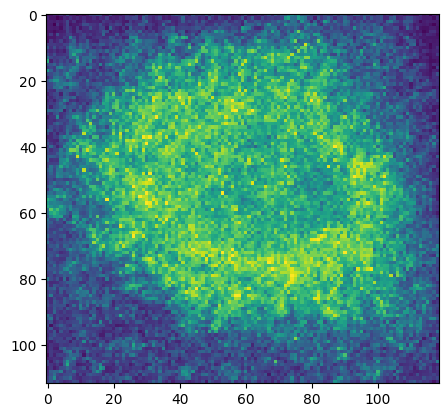

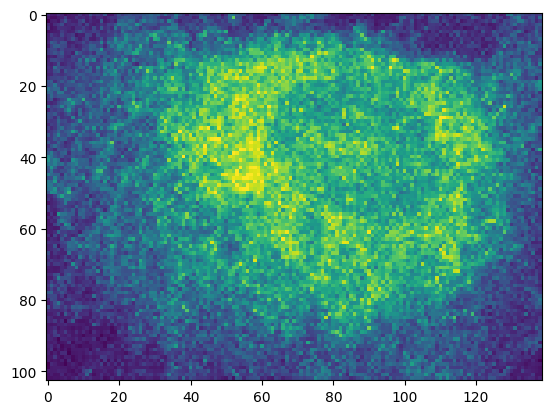

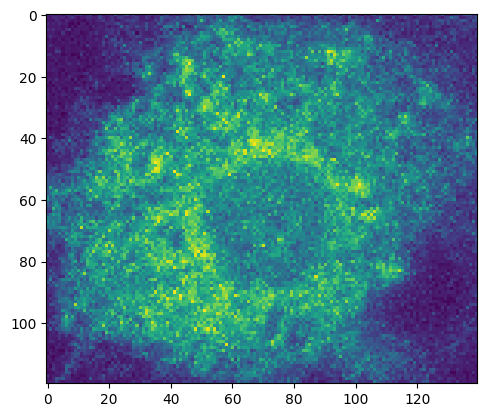

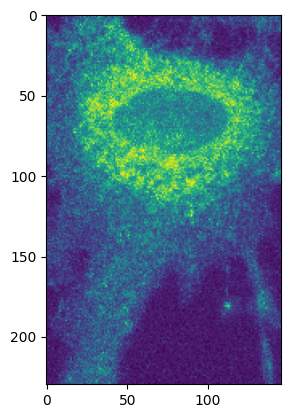

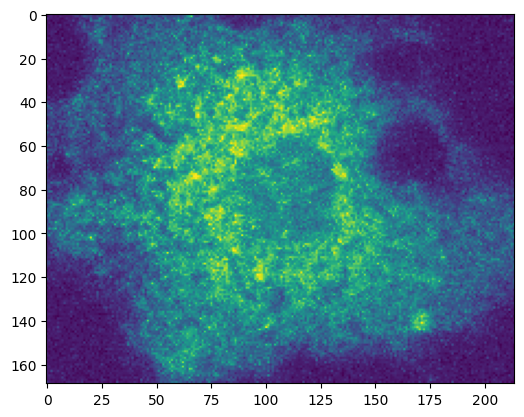

<Figure size 640x480 with 0 Axes>

In [16]:
for i in range(len(cropped_images)):
    plt.imshow(cropped_images[i]+cropped_images_nuclei[i])
    plt.figure(i+1)
plt.show()


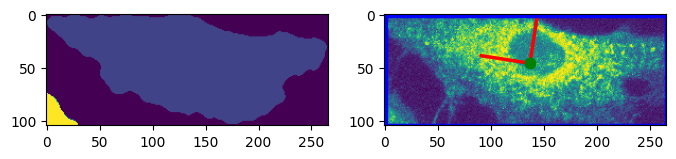

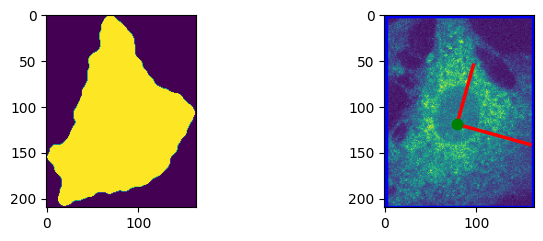

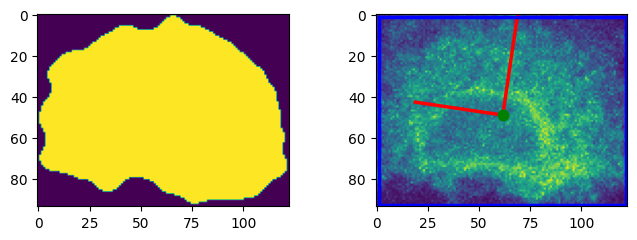

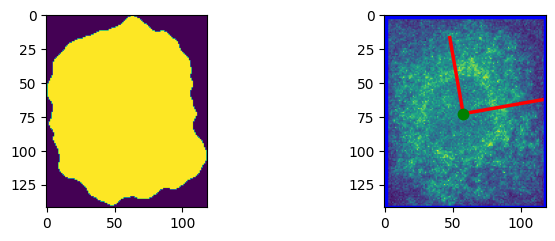

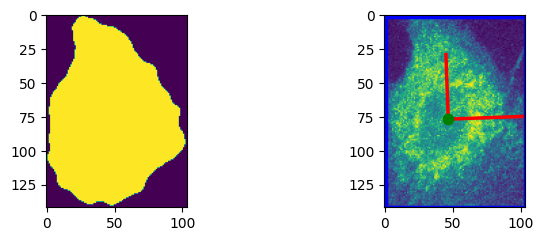

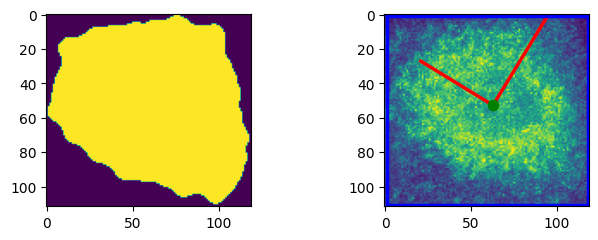

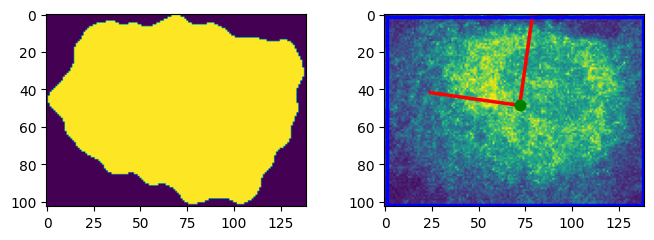

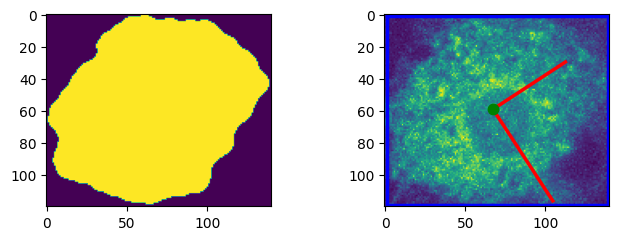

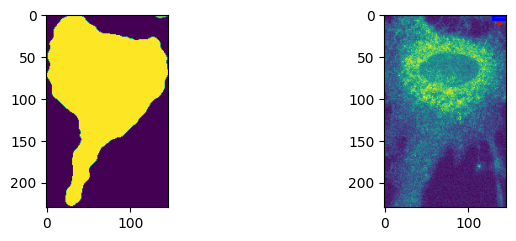

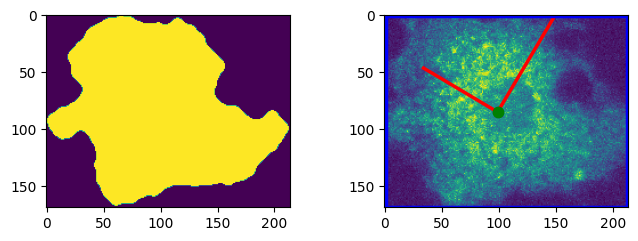

In [17]:
    
import math

for i in range(len(cropped_images)):
    image = cropped_images[i]
    nucleo=cropped_images_nuclei[i]
    label_img = label(image)
    region = regionprops(label_img)
    
    y0, x0 = region[0].centroid
    orientation = region[0].orientation
    x1 = x0 + math.cos(orientation) * 0.5 * region[0].major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * region[0].major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * region[0].minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * region[0].minor_axis_length
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 2.5))
      
    ax0.imshow(image, vmin=image.min(), vmax=image.max())    
    
    ax1.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax1.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax1.plot(x0, y0, '.g', markersize=15)
        
    minr, minc, maxr, maxc = region[0].bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax1.plot(bx, by, '-b', linewidth=2.5)
    plt.imshow(image+nucleo)
    fig.savefig('%s' %i + '%s' %name +  '.png' ) 
    plt.figure(i+1)
    plt.show